In [68]:
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import category_encoders as ce

from james_stein_custom import _JamesSteinEncoder



--- Análise Quantitativa (PSI) ---

Índice de Estabilidade Populacional (PSI):
  - PSI para 'custo_fn': 0.0535
  - PSI para 'custo_fp': 0.0331

--- Análise Visual (Distribuições) ---


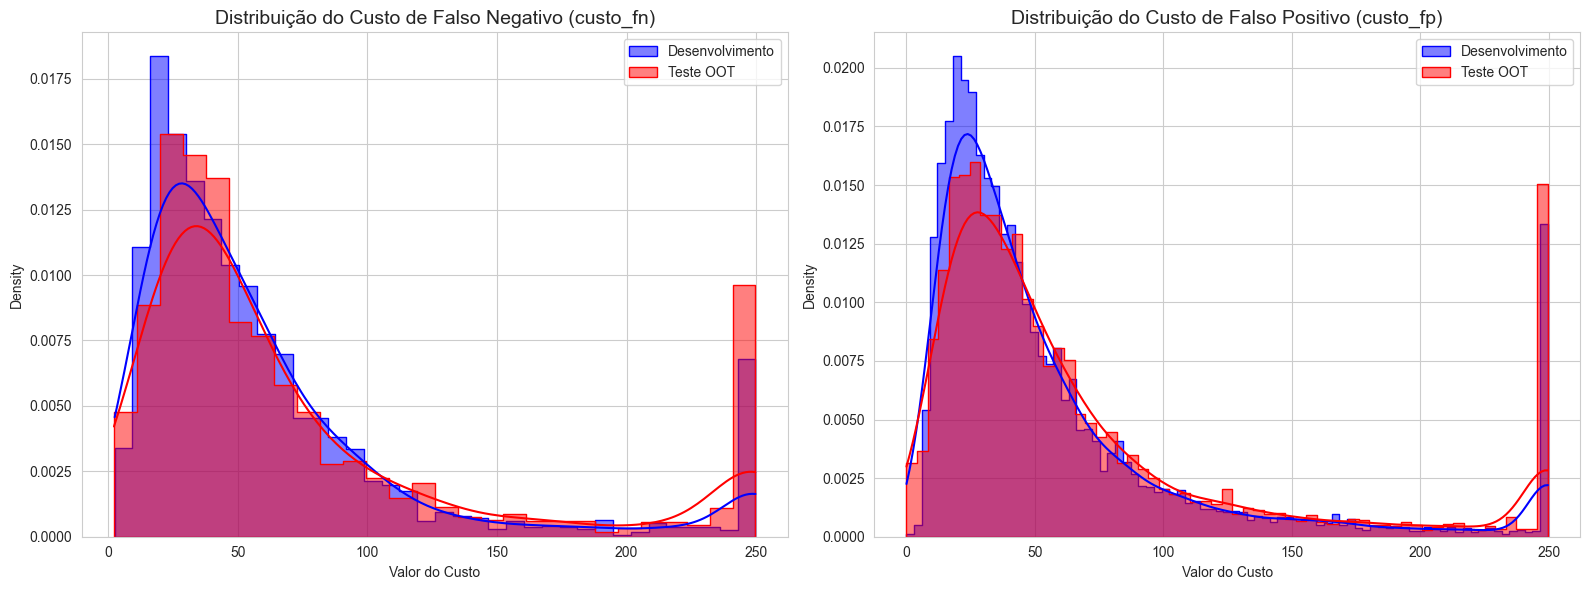

In [69]:
def calcular_psi(
    expected: pd.Series, actual: pd.Series, buckets: int = 10
) -> float:
    """
    Calcula o Índice de Estabilidade Populacional (PSI) para uma variável.

    Args:
        expected (pd.Series): A série de dados da população de referência (ex: treino/desenvolvimento).
        actual (pd.Series): A série de dados da população atual (ex: teste/OOT).
        buckets (int): O número de faixas (bins) para discretizar a variável.

    Returns:
        float: O valor do PSI.
    """
    # Define os pontos de corte dos buckets com base na população de referência (expected)
    breakpoints = np.quantile(expected, q=np.linspace(0, 1, buckets + 1))
    
    # Adiciona valores infinitos para garantir que todos os dados sejam incluídos
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf

    # Discretiza as duas séries de dados usando os mesmos pontos de corte
    expected_binned = pd.cut(expected, bins=breakpoints, labels=False, include_lowest=True)
    actual_binned = pd.cut(actual, bins=breakpoints, labels=False, include_lowest=True)

    # Calcula a distribuição percentual para cada bucket
    df_expected = pd.DataFrame({'expected': expected_binned.value_counts(normalize=True)})
    df_actual = pd.DataFrame({'actual': actual_binned.value_counts(normalize=True)})
    
    # Junta as duas distribuições
    psi_df = df_expected.join(df_actual, how='outer').fillna(0)

    # Tratamento para evitar divisão por zero ou log de zero
    psi_df.replace(0, 0.0001, inplace=True)
    psi_df['psi'] = (psi_df['actual'] - psi_df['expected']) * np.log(psi_df['actual'] / psi_df['expected'])
    
    return psi_df['psi'].sum()

try:
    treino_df = pd.read_csv("../data/dev/train.csv", index_col=0)
    validacao_df = pd.read_csv("../data/dev/val.csv", index_col=0)
    teste_oot_df = pd.read_csv("../data/dev/test.csv", index_col=0)

    dev_df = pd.concat([treino_df, validacao_df], ignore_index=True)
    
    dev_df['custo_fp_tratado'] = dev_df['custo_fp'].clip(lower=0)
    dev_df['custo_fn_tratado'] = dev_df['custo_fn'].clip(lower=0)
    teste_oot_df['custo_fp_tratado'] = teste_oot_df['custo_fp'].clip(lower=0)
    teste_oot_df['custo_fn_tratado'] = teste_oot_df['custo_fn'].clip(lower=0)

except FileNotFoundError as e:
    print(f"Erro nos dados: {e}")
    exit()

print("\n--- Análise Quantitativa (PSI) ---")

custo_fn_dev = dev_df[dev_df['target'] == 1]['custo_fn_tratado']
custo_fn_oot = teste_oot_df[teste_oot_df['target'] == 1]['custo_fn_tratado']

custo_fp_dev = dev_df[dev_df['target'] == 0]['custo_fp_tratado']
custo_fp_oot = teste_oot_df[teste_oot_df['target'] == 0]['custo_fp_tratado']

psi_fn = calcular_psi(custo_fn_dev, custo_fn_oot)
psi_fp = calcular_psi(custo_fp_dev, custo_fp_oot)

print("\nÍndice de Estabilidade Populacional (PSI):")
print(f"  - PSI para 'custo_fn': {psi_fn:.4f}")
print(f"  - PSI para 'custo_fp': {psi_fp:.4f}")

print("\n--- Análise Visual (Distribuições) ---")
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico para custo_fn
sns.histplot(custo_fn_dev, color="blue", label='Desenvolvimento', ax=axes[0], kde=True, stat="density", element="step")
sns.histplot(custo_fn_oot, color="red", label='Teste OOT', ax=axes[0], kde=True, stat="density", element="step")
axes[0].set_title('Distribuição do Custo de Falso Negativo (custo_fn)', fontsize=14)
axes[0].set_xlabel('Valor do Custo')
axes[0].legend()

# Gráfico para custo_fp
sns.histplot(custo_fp_dev, color="blue", label='Desenvolvimento', ax=axes[1], kde=True, stat="density", element="step")
sns.histplot(custo_fp_oot, color="red", label='Teste OOT', ax=axes[1], kde=True, stat="density", element="step")
axes[1].set_title('Distribuição do Custo de Falso Positivo (custo_fp)', fontsize=14)
axes[1].set_xlabel('Valor do Custo')
axes[1].legend()

plt.tight_layout()
plt.show()


------------------------------ RELATÓRIO FINANCEIRO ------------------------------
LGD Assumido: 85.00%
Exposição Total (EAD) no Portfólio OOT: R$ 6,717,120.13
Perda de Crédito Real (Total Loss):     R$ 625,879.89
------------------------------------------------------------
COMPARAÇÃO DE PERDA ESPERADA (ECL):
  - ECL do XGBoost (Custo Dinâmico): R$ 766,188.93
  - ECL do Random Forest (Calibrado):  R$ 769,062.12
------------------------------------------------------------
ACURÁCIA DA PROVISÃO (ECL / Perda Real):
  - Acurácia do XGBoost:      122.42%
  - Acurácia do Random Forest:  122.88%
---------------------------------------------------------------------------------

------------------------------ ANÁLISE DE RISCO POR DECIL ------------------------------

Modelo XGBoost (Calibrado):
              perda_real % da Perda Total
decil_xgb                                
10         R$ 171,669.77           27.43%
9           R$ 58,202.37            9.30%
8           R$ 42,439.34           

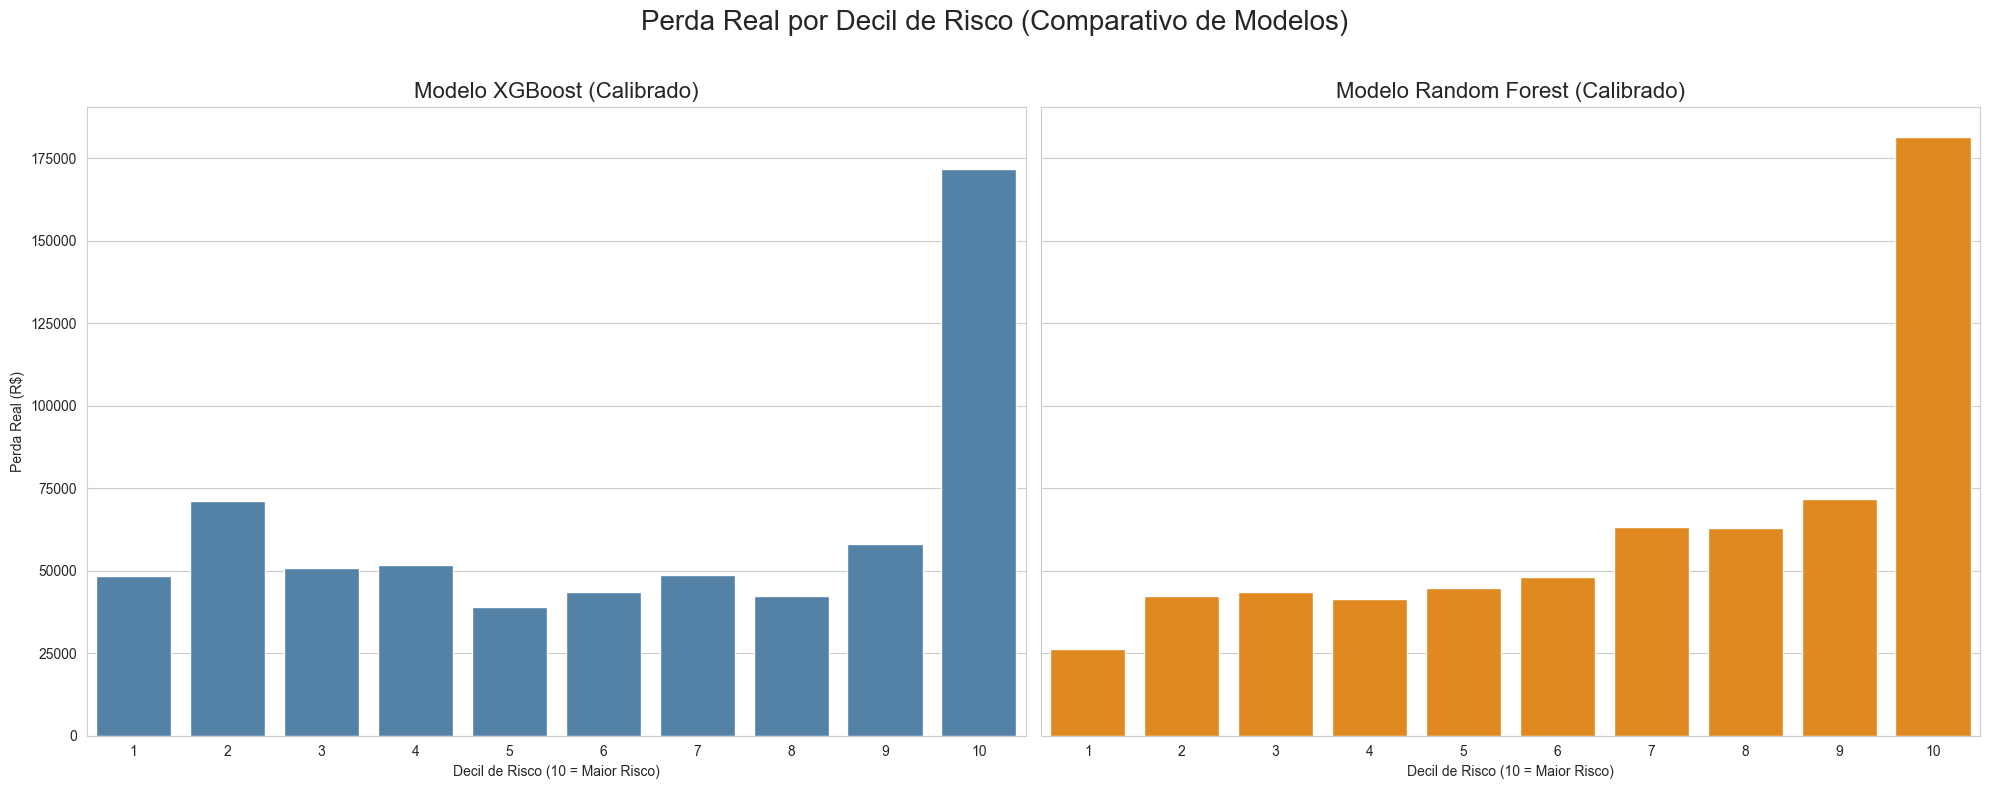

In [ ]:
def weighted_logloss_obj(y_pred_raw: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    y_true = dtrain.get_label()
    costs = dtrain.get_weight() 
    p = 1.0 / (1.0 + np.exp(-y_pred_raw))
    grad = costs * (p - y_true)
    hess = costs * p * (1.0 - p)
    return grad, hess

treino_df = pd.read_csv("../data/dev/train.csv", index_col=0)
validacao_df = pd.read_csv("../data/dev/val.csv", index_col=0)
teste_oot_df = pd.read_csv("../data/dev/test.csv", index_col=0)
dev_df = pd.concat([treino_df, validacao_df], ignore_index=True)

TARGET = 'target'
EAD_COL = 'valor_financiado'
COST_FN_COL = 'custo_fn'
COST_FP_COL = 'custo_fp'
FEATURES = [col for col in dev_df.columns if col not in [TARGET, 'data_originacao', 'id_contrato']]

X_dev, y_dev = dev_df[FEATURES], dev_df[TARGET]
X_oot, y_oot = teste_oot_df[FEATURES], teste_oot_df[TARGET]
costs_dev = np.where(y_dev == 1, dev_df[COST_FN_COL].clip(lower=0), dev_df[COST_FP_COL].clip(lower=0))

preprocessor = ColumnTransformer(
    transformers=[
        ('james_stein', _JamesSteinEncoder(min_samples=100), ['estado', 'id_varejo']),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=5), ['tipo_cliente']),
        ('target_encoder', ce.TargetEncoder(), [col for col in FEATURES if col.endswith('_bin')])
    ], 
    remainder='passthrough'
)

X_dev_processed = preprocessor.fit_transform(X_dev, y_dev)
dtrain_final = xgb.DMatrix(X_dev_processed, label=y_dev, weight=costs_dev)

best_xgb_params = {'eta': 0.11058668826319958, 'max_depth': 3, 'subsample': 0.9254051504525433, 'colsample_bytree': 0.5883639941170787, 
 'min_child_weight': 2.8085452364491768, 'lambda': 1.0586615281802251e-05, 'alpha': 0.6985583351140298, 
 'objective': 'binary:logistic', 'booster': 'gbtree', 'n_jobs': -1}

final_xgb_model = xgb.train(
    params=best_xgb_params,
    dtrain=dtrain_final,
    num_boost_round=500,
    obj=weighted_logloss_obj,
    verbose_eval=False
)

best_rf_params = {
    'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 
    'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None,
    'random_state': 42, 'n_jobs': -1
}
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(**best_rf_params))])

tscv_calib = TimeSeriesSplit(n_splits=5)
calibrated_rf = CalibratedClassifierCV(
    estimator=rf_pipeline, 
    method='isotonic', 
    cv=tscv_calib,
    n_jobs=-1
)
calibrated_rf.fit(X_dev, y_dev)

results_df = teste_oot_df.copy()
X_oot_processed = preprocessor.transform(X_oot) 


doot = xgb.DMatrix(X_oot_processed)
results_df['pd_xgb'] = final_xgb_model.predict(doot)
results_df['pd_rf_calibrated'] = calibrated_rf.predict_proba(X_oot)[:, 1]

LGD = 0.85
results_df['EAD'] = results_df[EAD_COL]
results_df['perda_real'] = results_df[TARGET] * LGD * results_df['EAD']
results_df['ECL_xgb'] = results_df['pd_xgb'] * LGD * results_df['EAD']
results_df['ECL_rf'] = results_df['pd_rf_calibrated'] * LGD * results_df['EAD']

total_ecl_xgb = results_df['ECL_xgb'].sum()
total_ecl_rf = results_df['ECL_rf'].sum()
total_perda_real = results_df['perda_real'].sum()

# Relatório Financeiro
print("\n" + "---" * 10 + " RELATÓRIO FINANCEIRO " + "---" * 10)
print(f"LGD Assumido: {LGD:.2%}")
print(f"Exposição Total (EAD) no Portfólio OOT: R$ {results_df['EAD'].sum():,.2f}")
print(f"Perda de Crédito Real (Total Loss):     R$ {total_perda_real:,.2f}")
print("-" * 60)
print("COMPARAÇÃO DE PERDA ESPERADA (ECL):")
print(f"  - ECL do XGBoost (Custo Dinâmico): R$ {total_ecl_xgb:,.2f}")
print(f"  - ECL do Random Forest (Calibrado):  R$ {total_ecl_rf:,.2f}")
print("-" * 60)
print("ACURÁCIA DA PROVISÃO (ECL / Perda Real):")
print(f"  - Acurácia do XGBoost:      {total_ecl_xgb / total_perda_real:.2%}")
print(f"  - Acurácia do Random Forest:  {total_ecl_rf / total_perda_real:.2%}")
print("---" * 27)

# Definição dos decis: 10 = maior risco, 1 = menor risco
results_df['decil_xgb'] = pd.qcut(results_df['pd_xgb'], 10, labels=range(1, 11), duplicates='drop')
results_df['decil_rf'] = pd.qcut(results_df['pd_rf_calibrated'], 10, labels=range(1, 11), duplicates='drop')

# Agrupamento e ordenação decrescente para mostrar maior risco primeiro
analise_xgb = results_df.groupby('decil_xgb')[['perda_real']].sum().sort_index(ascending=False)
analise_xgb['% da Perda Total'] = (analise_xgb['perda_real'] / total_perda_real) * 100

analise_rf = results_df.groupby('decil_rf')[['perda_real']].sum().sort_index(ascending=False)
analise_rf['% da Perda Total'] = (analise_rf['perda_real'] / total_perda_real) * 100

# Exibição formatada
print("\n" + "---" * 10 + " ANÁLISE DE RISCO POR DECIL " + "---" * 10)
analise_xgb_display = analise_xgb.copy()
analise_xgb_display['perda_real'] = analise_xgb_display['perda_real'].apply(lambda x: f"R$ {x:,.2f}")
analise_xgb_display['% da Perda Total'] = analise_xgb_display['% da Perda Total'].apply(lambda x: f"{x:.2f}%")

analise_rf_display = analise_rf.copy()
analise_rf_display['perda_real'] = analise_rf_display['perda_real'].apply(lambda x: f"R$ {x:,.2f}")
analise_rf_display['% da Perda Total'] = analise_rf_display['% da Perda Total'].apply(lambda x: f"{x:.2f}%")

print("\nModelo XGBoost (Calibrado):")
print(analise_xgb_display.to_string())

print("\nModelo Random Forest (Calibrado):")
print(analise_rf_display.to_string())
print("---" * 27)

# Gráfico de Barras
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Perda Real por Decil de Risco (Comparativo de Modelos)', fontsize=20)
sns.set_style("whitegrid")

sns.barplot(x=analise_xgb.index.astype(str), y=analise_xgb['perda_real'], ax=axes[0], color='steelblue', width=0.8)
axes[0].set_title('Modelo XGBoost (Calibrado)', fontsize=16)
axes[0].set_xlabel('Decil de Risco (10 = Maior Risco)')
axes[0].set_ylabel('Perda Real (R$)')
axes[0].invert_xaxis()

sns.barplot(x=analise_rf.index.astype(str), y=analise_rf['perda_real'], ax=axes[1], color='darkorange', width=0.8)
axes[1].set_title('Modelo Random Forest (Calibrado)', fontsize=16)
axes[1].set_xlabel('Decil de Risco (10 = Maior Risco)')
axes[1].set_ylabel('')
axes[1].invert_xaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()